In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('births.csv', index_col = "Date", parse_dates = True)


In [7]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [8]:
df.shape

(365, 1)

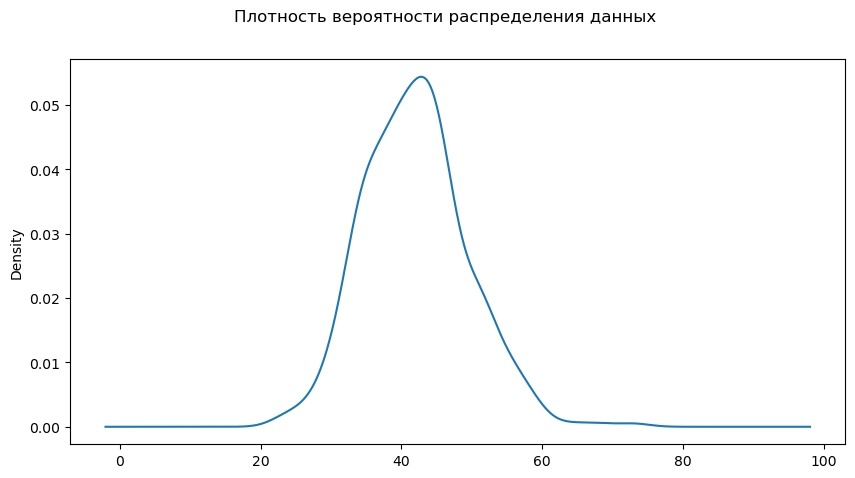

In [9]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
df.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

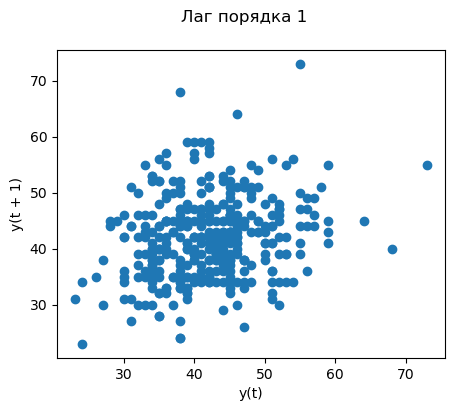

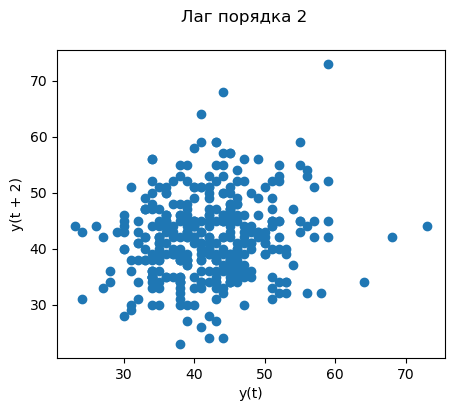

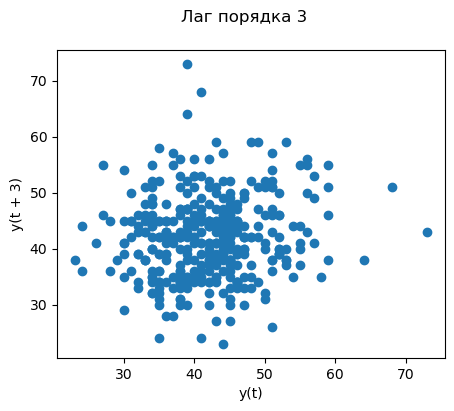

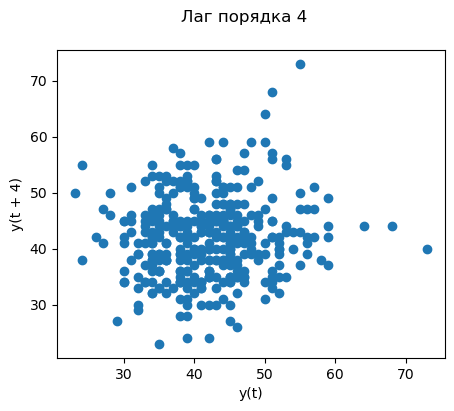

In [10]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(df, lag=i, ax=ax)
    pyplot.show()

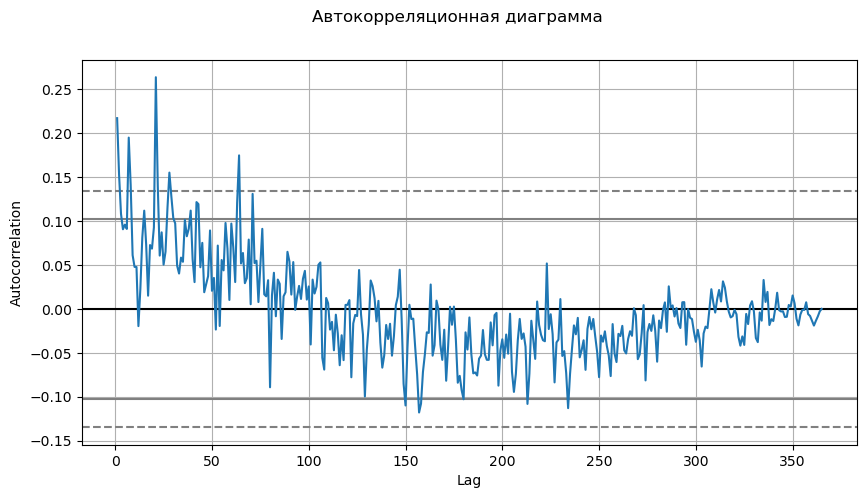

In [11]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(df, ax=ax)
pyplot.show()

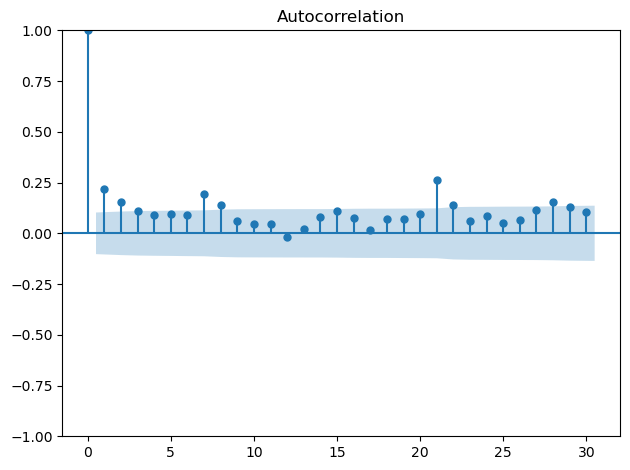

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=30)
plt.tight_layout()

In [13]:
df.index = pd.to_datetime(df.index)

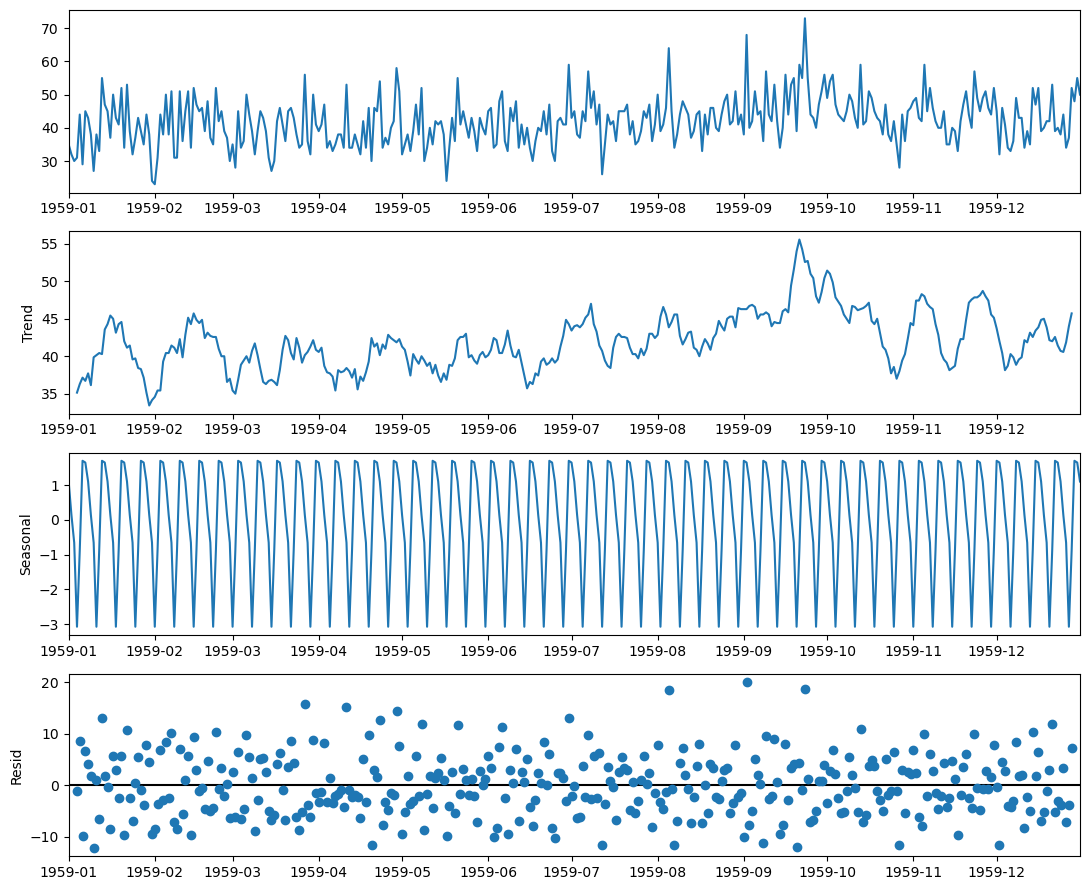

In [14]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(df)
decompose.plot()
 
plt.show()

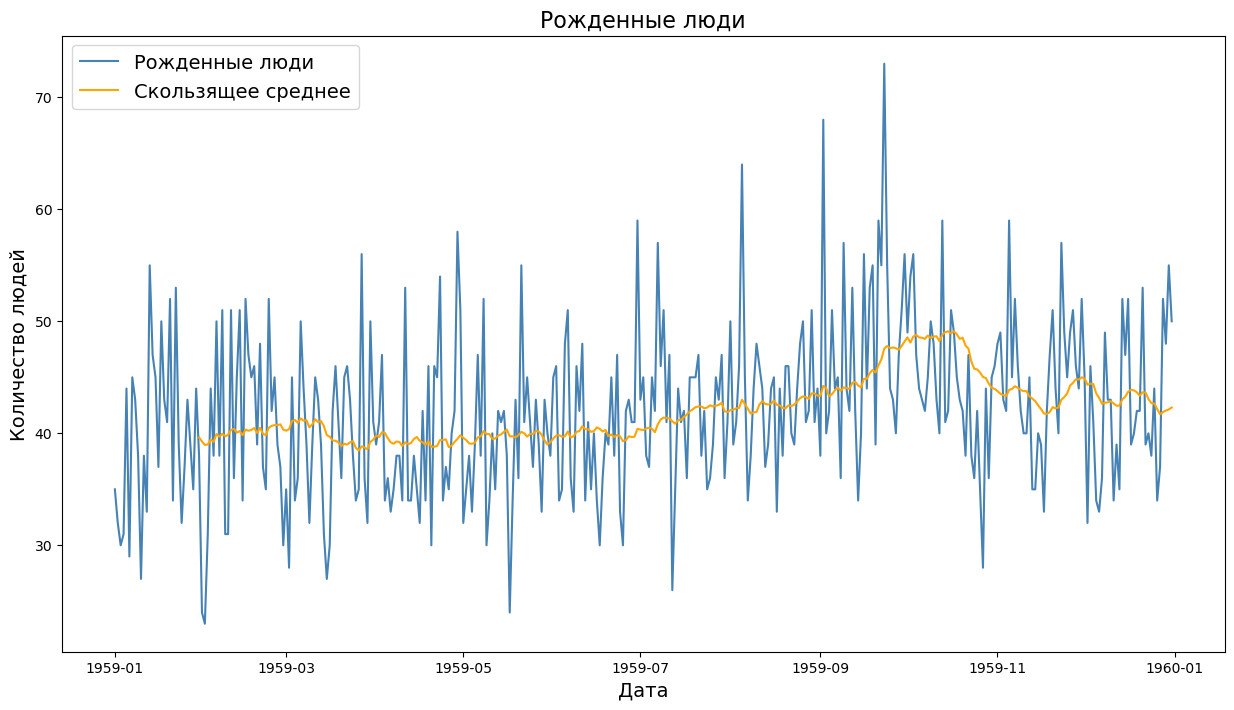

In [17]:
# зададим размер графика
plt.figure(figsize = (15,8))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(df, label = 'Рожденные люди', color = 'steelblue')
plt.plot(df.rolling(window = 30).mean(), label = 'Скользящее среднее', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Количество людей', fontsize = 14)
plt.title('Рожденные люди', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

In [19]:
# импортируем необходимую функцию 
from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(df['Births'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 5.2434129901498554e-05


In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [26]:
xnum = list(range(df.shape[0]))
Y = df['Births'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]

In [31]:
history_arima = [x for x in train]
history_es = [x for x in train]

In [32]:
arima_order = (6,1,0)

In [33]:
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])

In [34]:
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [35]:
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])

In [36]:
error_es = mean_squared_error(test, predictions_es, squared=False)

In [37]:
df['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
df['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

In [40]:
df['SMA'] = df['Births'].rolling(30, min_periods=1).mean()

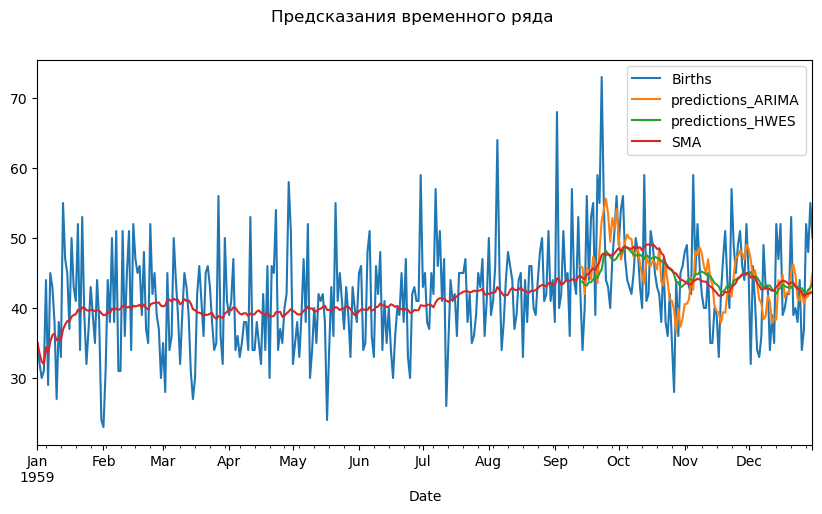

In [41]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
df.plot(ax=ax, legend=True)
pyplot.show()

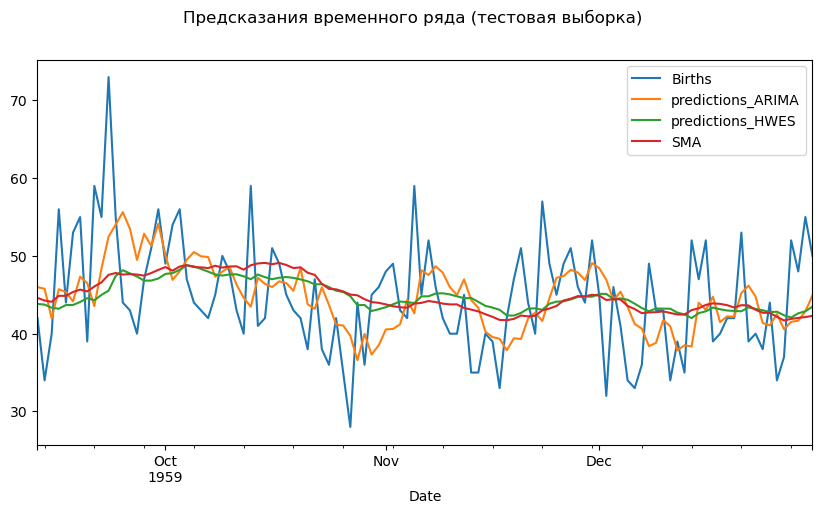

In [42]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
df[train_size:].plot(ax=ax, legend=True)
pyplot.show()

ARIMA и HWES близки к скользящему среднему

In [45]:
from gplearn.genetic import SymbolicRegressor

%pip install gplearn

In [46]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
est_gp = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [47]:
est_gp.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      7.25395e+55       26           368.24              N/A      1.93m
   1   168.80      3.08763e+11      190          137.664              N/A     57.31s
   2   187.17      1.23463e+10      190           137.64              N/A     54.87s
   3   126.69      3.36087e+22       14          63.3652              N/A     42.64s
   4   178.60      6.78824e+13       14          63.3685              N/A     53.37s
   5   123.38      1.01443e+14       10          58.1649              N/A     41.21s
   6    16.83        3.043e+14       25          57.1643              N/A     18.65s
   7    13.11      4.06308e+14        9          50.0916              N/A     19.34s
   8    15.99      4.05734e+14       22          50.0506              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [48]:
# Предсказания
y_gp = est_gp.predict(np.array(xnum_test).reshape(-1, 1))
y_gp[:10]

array([40.28938386, 36.55290694, 44.0910671 , 42.43899561, 47.00219962,
       45.03593076, 39.69664985, 46.57498875, 44.92532119, 43.89997191])

In [49]:
df['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_gp)

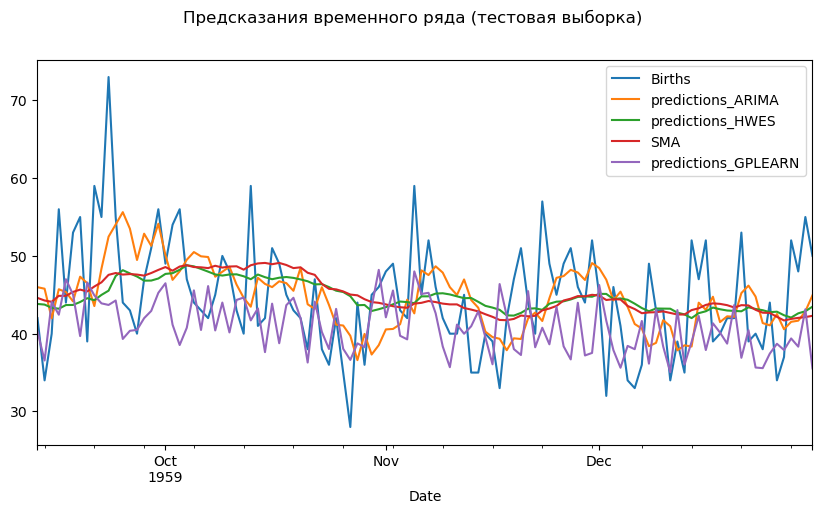

In [51]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
df[train_size:].plot(ax=ax, legend=True)
pyplot.show()